In [19]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, classification_report
import pandas as pd

In [20]:
# Define classes and their labels
classes = {'PNEUMONIA': 0, 'NORMAL': 1}
import os

# Load and preprocess the dataset
X = []
Y = []
for cls, label in classes.items():
    pth = f"/kaggle/input/chestdata/chest_xray/train/{cls}"
    for filename in os.listdir(pth):
        img = cv2.imread(os.path.join(pth, filename), 0) #path of each image
        img = cv2.resize(img, (200, 200)) #resizing to common size
        X.append(img.flatten() / 255.0)  # Flatten and normalize the image data
        Y.append(label) #label
X = np.array(X) # list of Flatten and normalize the image data
Y = np.array(Y) # list of lables

In [21]:
# Split the dataset into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, random_state=10, test_size=0.8)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.98)   #eg. 300/40,000 images, but carry 98% of info 
pca_train = pca.fit_transform(xtrain) #learns and picks the 300 imp features, (fit!)
pca_test = pca.transform(xtest) #transforms into resuced dimention directly from the process it has learnt (hence, no fit!)
# Train Support Vector Classifier
sv = SVC()
sv.fit(pca_train, ytrain) #learns from the training set, think of it as getting formula
print(sv.kernel) 

# Evaluate the model
train_score = sv.score(pca_train, ytrain) #applying formula for test data, 80% of results
test_score = sv.score(pca_test, ytest) #applying formula for train data, to finally get 100% of results
print("Training Score:", train_score)   # how well it has learnt 
print("Testing Score:", test_score)     #compare accurace here

rbf
Training Score: 0.9942473633748802
Testing Score: 0.9515935777618021


In [22]:
# Predict test labels
y_pred = sv.predict(pca_test)
labels = np.unique(ytest)

# Confusion Matrix
cm = confusion_matrix(ytest, y_pred)
print("\nCONFUSION MATRIX")
print(cm)

# Classification Report (Precision, Recall, F1 for each class)
print("\nCLASSIFICATION REPORT")
print(classification_report(ytest, y_pred))


CONFUSION MATRIX
[[3032   68]
 [ 134  939]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3100
           1       0.93      0.88      0.90      1073

    accuracy                           0.95      4173
   macro avg       0.95      0.93      0.94      4173
weighted avg       0.95      0.95      0.95      4173



In [23]:
y_pred = sv.predict(pca_test)
labels = np.unique(ytest)
cm = confusion_matrix(ytest, y_pred, labels=labels)

# Accuracy and F1
accuracy = accuracy_score(ytest, y_pred) * 100
f1 = f1_score(ytest, y_pred, average='macro') * 100  # or 'weighted'

# Sensitivity (Recall) per class
sensitivity_per_class = []
specificity_per_class = []

for i, label in enumerate(labels):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_per_class.append(sensitivity * 100)
    specificity_per_class.append(specificity * 100)

# Display
print(f"\nAccuracy: {accuracy:.2f}%")
print(f"F1 Score (macro): {f1:.2f}%\n")

for i, label in enumerate(labels):
    print(f"Class {label} - Sensitivity: {sensitivity_per_class[i]:.2f}%, Specificity: {specificity_per_class[i]:.2f}%")


Accuracy: 95.16%
F1 Score (macro): 93.53%

Class 0 - Sensitivity: 97.81%, Specificity: 87.51%
Class 1 - Sensitivity: 87.51%, Specificity: 97.81%


In [24]:
# Display sample images and predictions
def display_samples(folder, title, num_samples=9):
    plt.figure(figsize=(12, 8))
    c = 1
    for i, filename in enumerate(os.listdir(folder)[:num_samples]):
        img = cv2.imread(os.path.join(folder, filename), 0)
        img = cv2.resize(img, (200, 200)).flatten() / 255.0  # Preprocess the test image
        prediction = sv.predict(pca.transform([img]))  # Predict using the trained SVM
        dec = {0: 'PNEUMONIA', 1: 'NORMAL'}
        plt.subplot(3, 3, c)
        plt.title(dec[prediction[0]])  # Map prediction to human-readable label
        plt.imshow(img.reshape(200, 200), cmap='gray')  # Display the image
        plt.axis('off')
        c += 1
    plt.suptitle(title)
    plt.show()

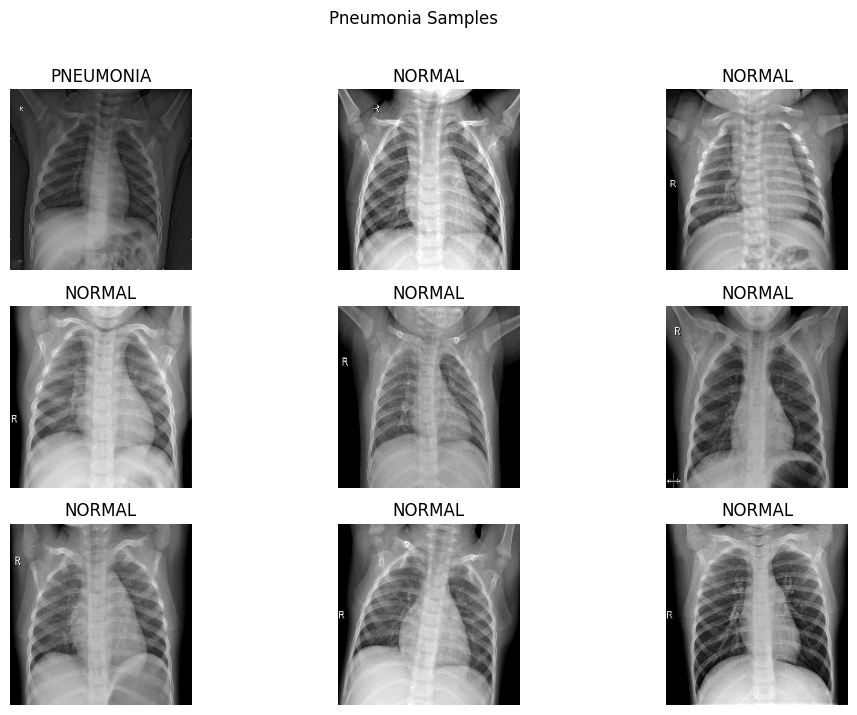

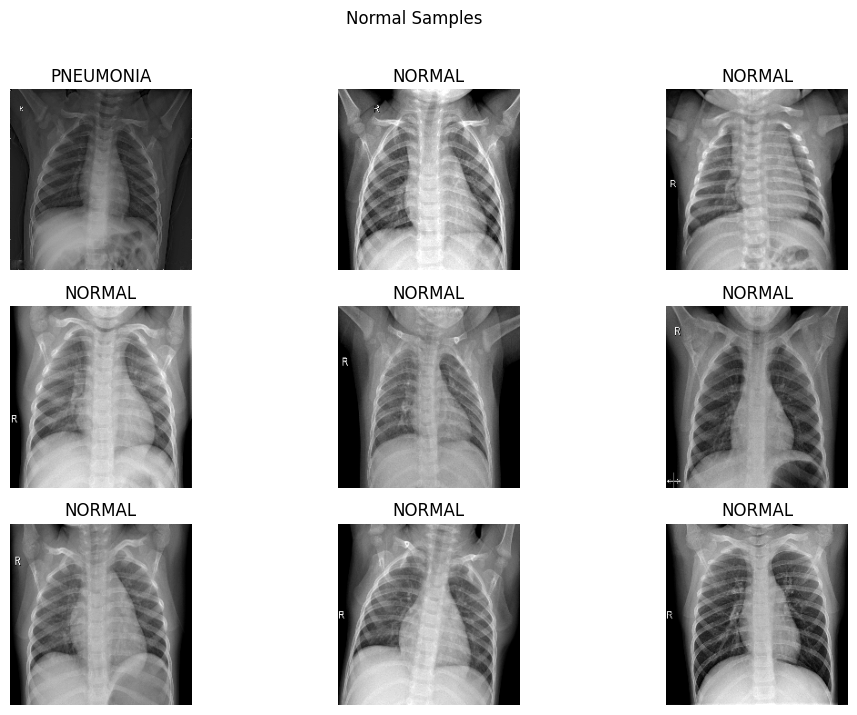

In [25]:
# Define class labels
dec = {0: 'PNEUMONIA', 1: 'NORMAL'}
# Display sample images and predictions for each tumor type

chestxray_folders = ['PNEUMONIA', 'NORMAL',]
for chestxray_folder in chestxray_folders:
    folder_path = f"/kaggle/input/chestdata/chest_xray/train/{cls}"
    title = f'{chestxray_folder.replace("_", " ").title()} Samples'
    display_samples(folder_path, title)

In [26]:
# Count the occurrences of each tumor type
chestxray_counts = {dec[label]: np.sum(Y == label) for label in classes.values()}

# Create a table to represent the tumor counts
table_data = {
    'Index': range(1, len(classes) + 1),
    'Chestxray Type': list(chestxray_counts.keys()),
    'Count': list(chestxray_counts.values())
}

# Convert to DataFrame
chestxray_table = pd.DataFrame(table_data)

# Print the table without styling
print("Chestxray Type Counts:\n")
print(chestxray_table.to_string(index=False))  # index=False hides the extra index column

Chestxray Type Counts:

 Index Chestxray Type  Count
     1      PNEUMONIA   3875
     2         NORMAL   1341


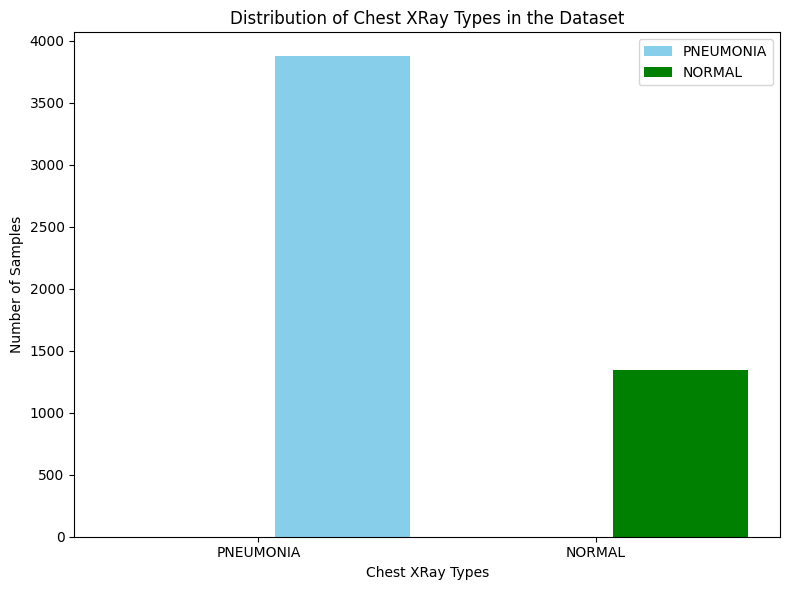

In [27]:
# Create a histogram of tumor types with different colors
chestxray_labels = [dec[label] for label in Y]
colors = ['skyblue', 'green']
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
for label, color in zip(classes.values(), colors):
    plt.hist(np.array(chestxray_labels)[Y == label], bins=len(classes), rwidth=0.8, color=color, label=dec[label])
plt.xlabel('Chest XRay Types')
plt.ylabel('Number of Samples')
plt.title('Distribution of Chest XRay Types in the Dataset')
plt.xticks(range(len(classes)), list(classes.keys()))
plt.legend()
plt.tight_layout()
plt.show()